In [1]:
### packages ###
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import modelbase
from tqdm.notebook import tqdm
from modelbase.ode import Simulator
from typing import Iterable, Dict, Tuple, Optional, Any, List, Union
import itertools as it
from matplotlib import cm

In [2]:
%%capture
cd ..

In [3]:
from models import get_model

In [4]:
%%capture
cd analyses/

In [5]:
y0 = {
    "PQ": 11.027139850905353,
    "PC": 1.8895071932002812,
    "Fd": 3.8690237263896705,
    "ATP": 1.620195002854852,
    "NADPH": 0.4882103700673736,
    "H": 0.0022147075094596015,
    "LHC": 0.8023074419510501,
    "Psbs": 0.9607146039898598,
    "Vx": 0.950783616933656,
    "PGA": 0.9913970817549008,
    "BPGA": 0.0005355311557548053,
    "GAP": 0.0062630116252017295,
    "DHAP": 0.13778623933075737,
    "FBP": 0.006126990841013743,
    "F6P": 0.31166103888161867,
    "G6P": 0.7168203893211117,
    "G1P": 0.041575582577936025,
    "SBP": 0.01311315151803723,
    "S7P": 0.15782894767619207,
    "E4P": 0.00732079113061801,
    "X5P": 0.022396849486562384,
    "R5P": 0.03751472214765548,
    "RUBP": 0.13153657267999222,
    "RU5P": 0.015005888732707041,
    "MDA": 5.85270097771621e-06,
    "ASC": 9.999994138785292,
    "H2O2": 3.4273920330125316e-06,
    "DHA": 8.513863740903352e-09,
    "GSH": 9.999999991725186,
    "GSSG": 4.137406632226743e-09,
    "TR_ox": 0.9,
    "E_inactive": 4.7368421052631575,
}

In [6]:
m = get_model() #get model

In [7]:
#add new parameters with values from Dave Kramer 
m.add_parameter("b6f_content", 1)
m.add_parameter("max_b6f", 500)
m.add_parameter("pKreg", 6.5)

##forward rate constant, consisiting of pH depending component that pumps protons into lumen
##protonation rate, which depends on pH and multiplied with scaling parameter
def k_b6f(pH , pKreg, b6f_content, max_b6f):
    pHmod=(1 - (1 / (10 ** (pH - pKreg) + 1)))
    b6f_deprot=pHmod*b6f_content
    return b6f_deprot * max_b6f

m.add_algebraic_module(module_name="k_b6f",
        function=k_b6f,
        compounds=["pH"],
        derived_compounds=["k_b6f"],
        parameters=["pKreg", "b6f_content", "max_b6f"],)

##because reaction is reversible forward rate constant/eq constant = reverse rate constant
#simple reaction rate, concentration substrates * forwards - concentration products - backwards
##!!!!!!!check whether it is necessary to keep PQ in fraction and not total number!!!!!!!
def vB6f(PC, PCred, PQ, PQred, k_b6f ,Keq_cytb6f, kCytb6f):    
    k_b6f_reverse = k_b6f / Keq_cytb6f
    f_PQH2=PQred/(PQred+PQ) #want to keep the rates in terms of fraction of PQHs, not total number
    f_PQ=1-f_PQH2
    return (f_PQH2*PC*k_b6f - f_PQ*PCred*k_b6f_reverse)* kCytb6f 

m.add_reaction(rate_name="vB6f",
        function=vB6f,
        stoichiometry={"PC": -2, "PQ": 1, "H": 4 / m.get_parameter("bH")},
        modifiers=["PQred", "PCred", "k_b6f", "Keq_B6f"],
        dynamic_variables=["PC","PCred", "PQ", "PQred", "k_b6f","Keq_B6f"],
        parameters=["kCytb6f"],
        reversible=True,
    )

In [8]:
m.add_parameter("ATPturnover", 90)


def ATP_gamma(Pi,ATP,ADP,convf):
    return (ATP/convf)/((ADP/convf)*(Pi/1000))

m.add_algebraic_module_from_args(
        module_name="ATP_gamma",
        function=ATP_gamma,
        args=["Pi", "ATP", "ADP", "convf"],
        derived_compounds=["ATP_gamma"])

def deltagATPsyn(pH,gammaATP,DeltaG0_ATP,dG_pH, HPR, pHstroma, RT):
    DG = DeltaG0_ATP - dG_pH * HPR * (pHstroma - pH) + RT* np.log(gammaATP)
    return DG

m.add_algebraic_module_from_args(
    module_name="DeltaGATPsyn",
    function=deltagATPsyn,
    args=["pH","ATP_gamma","DeltaG0_ATP","dG_pH", "HPR", "pHstroma", "RT"],
    derived_compounds=["DeltaGATPsyn"])


m.remove_reaction("vATPsynthase")

def vATPsynthase2(DeltaGATPsyn, ATPturnover):
    return -DeltaGATPsyn*ATPturnover

m.add_reaction(
        rate_name="vATPsynthase",
        function=vATPsynthase2,
        stoichiometry={
            "H": -m.get_parameter("HPR") / m.get_parameter("bH"),
            "ATP": 1 * m.get_parameter("convf"),
        },
        modifiers=["DeltaGATPsyn"],
        dynamic_variables=["DeltaGATPsyn"],
        parameters=["ATPturnover"],
        reversible=True)


In [9]:
def pam_analysis(
    s: Simulator,
    t_relax: float,
    t_pulse: float,
    pfd_dark: float,
    pfd_illumination: float,
    pfd_pulse: float,
    adaption :float,
    time_adaption : float,
    integrator_kwargs: Dict[str, Any] = None,
) -> None:
    if integrator_kwargs is None:
        integrator_kwargs = {}
    s.update_parameter("pfd", adaption)
    s.simulate(time_adaption)
    print("adaption done with:",str(time_adaption)+" and "+str(adaption))
    t = list(it.accumulate(it.chain.from_iterable((t_relax, t_pulse) for i in range(32))))
    for f in range(len(t)):
        t[f]= t[f] + time_adaption
    pfds = list(
        [pfd_dark, pfd_pulse] * 2
        + [pfd_illumination, pfd_pulse] * 10
        + [pfd_dark, pfd_pulse] * 8
    )
    for t_end, pfd in zip(t, pfds):
        s.update_parameter("pfd", pfd)
        s.simulate(t_end, **integrator_kwargs)


def get_light(s: Simulator) -> np.ndarray:
    values = [
        list(it.repeat(par["pfd"], len(t)))
        for par, t in zip(s1.simulation_parameters, s1.get_time(concatenated=False))
    ]
    return np.fromiter(it.chain(*values), dtype="float")


def get_npq(
    s: Simulator,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Calculates the non-photochemical quenching from the extracted
    important points of the PAM simulations

    Returns
    -------
    Fm: Fm (first element of list) and Fm' values
    NPQ: Calculated NPQ values
    tm: Exact time points of peaks in PAM trace
    Fo: Fo (first element of list) and Ft' values
    to: Exact time points of Fo and Ft' values
    """
    # container for lists. Each list contains the positions of fluorescence values for one peak
    z = []

    # container for position of Fo'
    o = []
    cnt = 0

    light = get_light(s1)
    max_light = max(light)
    F = s.get_full_results_df()["Fluo"].values
    t = s.get_time()

    while cnt < len(light):
        if light[cnt] == max_light:
            # temporary container for all F==maxlight. For each peak it is renewed
            h = []
            while cnt != len(light) and light[cnt] == max(light):
                h.append(cnt)
                cnt += 1
            z.append(h)
            o.append(h[0] - 1)  # value directly at the bottom of peak is Fo
        else:
            cnt += 1
    # Fm is the maximal value for each peak sequence
    peaks = [i[np.argmax(F[i])] for i in z]
    Fm = F[peaks]
    tm = t[peaks]
    Fo = F[o]
    to = t[o]
    NPQ = (Fm[0] - Fm) / Fm
    qPSII = (Fm-Fo) / Fm
    return Fm, NPQ, qPSII ,tm, Fo, to

In [10]:
### Light-induced chlorophyll (Chl) fluorescence induction kinetics (Kautsky effect) ###
def Fs_det (s:Simulator,adaption_pfd:float, adaption_time:float, measuring_pfd:float, measuring_time:float):
    time=[adaption_time, measuring_time+adaption_time]
    pfd=[adaption_pfd,measuring_pfd]    
    for t, light in zip(time, pfd):
        print(light)
        print(t)
        s.update_parameter("pfd", light)
        s.simulate(t)
    return (s.get_full_results_df()["Fluo"].iloc[-1]/max(s.get_full_results_df()["Fluo"]))

In [11]:
def get_Fs(s:Simulator, start:float, end: float) -> Tuple[int, int, np.array]:
    c = s.get_full_results_df()
    g = (s.get_full_results_df()["Fluo"][start:end])/max(c["Fluo"])
    for i in range(20,len(g)):
        if i == (len(g)-4):
            ss = g.iloc[-4]
            print("finished with Fs:", ss, "at i:",i)
            break
        ssc=g.iloc[i]
        control = g.iloc[i+1]
        control2 = g.iloc[i+2]
        control3 = g.iloc[i+3]
        control4= g.iloc[i+4]
        if control < ((0.0000000001*ssc)+ssc and control > (ssc-(0.0000000001*ssc))) and control2 < (((0.000000001*ssc)+ssc) and control2 > (ssc-(0.0000000001*ssc))) and control3 < ((0.0000000001*ssc)+ssc and control3 > (ssc-(0.0000000001*ssc))) and control4 < ((0.0000000001*ssc)+ssc and control4 > (ssc-(0.0000000001*ssc))):
            ss = ssc
            print("finished with Fs:", ss, "at i:",i)
            break
    return ss, i, g

def constant_light_cond2(s: Simulator, days: float, measuring_day: int, 
                        time_relax: float, time_pulse: float,
                        pfd_dark:float, pfd_light:float, pfd_pulse: float,):
    pfds = [120,240,120,50]
    t = [5400, 46800+5400, 46800+5400*2, 46800+28800+5400*2]
    measuring_pfds = list([pfd_dark,pfd_pulse] * 2
        + [pfd_light,pfd_pulse] * 10
        + [pfd_dark,pfd_pulse] * 8)
    measuring_time = list(it.accumulate(it.chain.from_iterable((time_relax, time_pulse) for i  in range(32))))
    for f in range(len(measuring_time)):
        measuring_time[f]= measuring_time[f] + (7200+46800+5400*2) + (86400*measuring_day)
    special_t =[5400, 46800+5400, 46800+5400*2, 7200+46800+5400*2, 86400]
    special_pfds =[120,240,120,50,50]
    for d_time in range(0,(days+1)):
        update_t = [i + (86400*(d_time)) for i in t]
        if d_time != measuring_day:
            for time, pfd in zip(update_t, pfds):
                    #print(time,pfd)
                    s.update_parameter("pfd", pfd)
                    s.simulate(time)
        else:
            update_special_t = [i+(86400*d_time) for i in special_t]
            for time, pfd in zip(update_special_t, special_pfds):
                #print(time, pfd)
                s.update_parameter("pfd", pfd)
                s.simulate(time)
                if time == (7200+46800+5400*2) + (86400*d_time):
                    for time, pfd in zip(measuring_time, measuring_pfds):
                        #print(time,pfd)
                        s.update_parameter("pfd", pfd)
                        s.simulate(time)
                        

In [12]:
PQ_pool_list = []
PQ_pool_dict ={}
#actiniclight_list = np.linspace(100,1000,20)
#kb6f_multiplier = np.linspace(0.05,1,20)
actiniclight_list =[200,250,300,350,400,600,800,1000]
kb6f_multiplier = [0.25,0.5,1,2,4]
s1= Simulator(m)
s1.initialise(y0)
s1.update_parameter("kcyc", 0.0)
s1.clear_results()
ss_dict ={}
ss_list=[]
i_dict={}
i_list=[]
g_dict={}
g_list=[]
Fluo=[]
for h in actiniclight_list:
    PQ_pool_list = []
    ss_list=[]
    i_list=[]
    g_list=[]
    s1= Simulator(m)
    s1.initialise(y0)
    s1.update_parameter("kcyc", 0.0)
    s1.clear_results()
    pam_analysis(s1,t_relax=120,t_pulse=0.8,pfd_dark=50, pfd_illumination=h,
                     pfd_pulse=5000,adaption=50,time_adaption=10000)
    fluxes = s1.get_fluxes_df()
    
    concentrations = s1.get_full_results_df()
    Fluo.append(concentrations["Fluo"])
    ss,i,g = get_Fs(s1, 11340,11440)
    ss_list.append(ss)
    i_list.append(g.index[i])
    g_list.append(g)
    PQ_pool_list.append(s1.get_full_results_df()["PQ_redoxstate"][g.index[i]])
    key = "ppfd: "+ str(h)
    ss_dict[key]=ss_list
    g_dict[key]=g_list
    i_dict[key]=i_list
    PQ_pool_dict[key]=PQ_pool_list
Fm, NPQ, qPSII, tm, Fo, to=get_npq(s1)

adaption done with: 10000 and 50
finished with Fs: 0.25462817892920847 at i: 20
adaption done with: 10000 and 50
finished with Fs: 0.263085811477244 at i: 20
adaption done with: 10000 and 50
finished with Fs: 0.26936069365012744 at i: 20
adaption done with: 10000 and 50
finished with Fs: 0.2741614164456648 at i: 20
adaption done with: 10000 and 50
finished with Fs: 0.27790963411638137 at i: 20
adaption done with: 10000 and 50
finished with Fs: 0.2879693261579705 at i: 20
adaption done with: 10000 and 50
finished with Fs: 0.2954972511870427 at i: 48
adaption done with: 10000 and 50
finished with Fs: 0.30305443092135365 at i: 41


In [13]:
color = cm.rainbow(np.linspace(0, 1, 8))

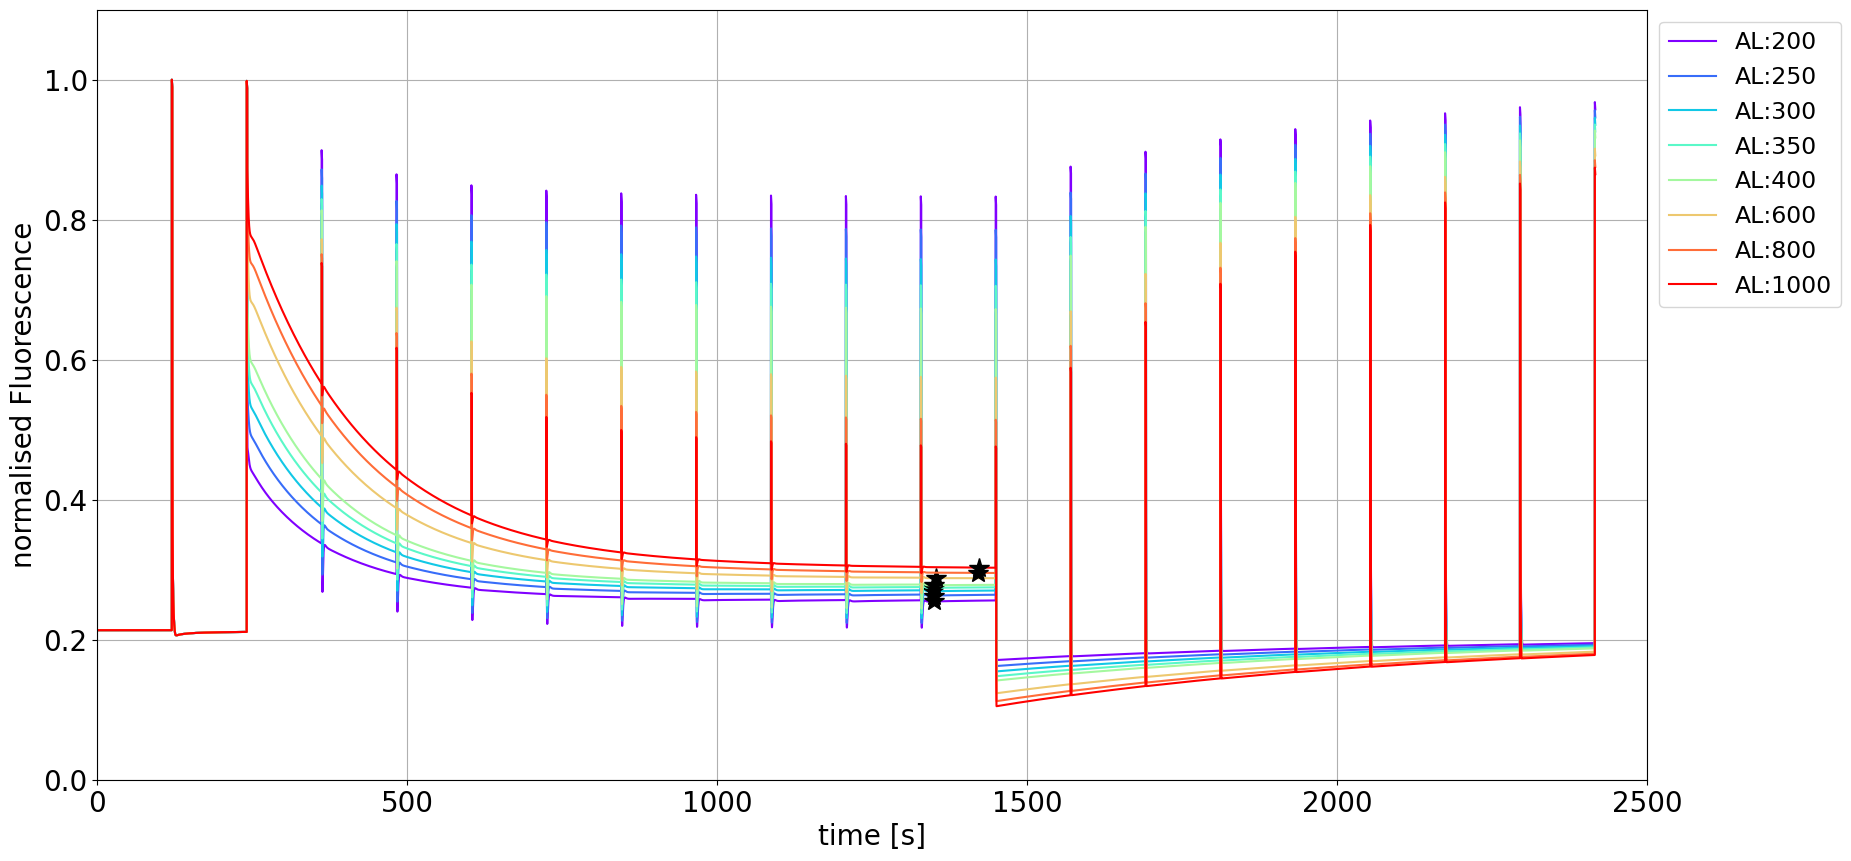

In [14]:
fig,ax=plt.subplots(figsize=(20,10))
ax.tick_params(axis='both', which='major', labelsize=20)
for j in range(len(Fluo)):
    ax.plot(Fluo[j]/max(Fluo[j]),color = color[j], label="AL:"+str(actiniclight_list[j]))
    ax.plot(list(i_dict.values())[j],list(ss_dict.values())[j], color= "black",marker ="*", markersize=15)
ax.set(xlim=(10000,12500),
       ylim=(0,1.1))
ax.set_ylabel("normalised Fluorescence", fontsize=20)
ax.set_xlabel("time [s]", fontsize=20)

ax.set_xticklabels([0,500,1000,1500,2000,2500])
ax.grid()
ax.legend(bbox_to_anchor=(1, 1), fontsize=17)

['PC', 'PCred', 'PQ', 'PQred', 'k_b6f', 'Keq_B6f', 'kCytb6f']

  0%|          | 0/8 [00:00<?, ?it/s]

adaption done with: 10000 and 50
finished with Fs: 0.3042133766297653 at i: 69
adaption done with: 10000 and 50
finished with Fs: 0.2956419125313361 at i: 74
adaption done with: 10000 and 50
finished with Fs: 0.2869787561285877 at i: 86
adaption done with: 10000 and 50
finished with Fs: 0.28086097041679314 at i: 81
adaption done with: 10000 and 50
finished with Fs: 0.27656594838240234 at i: 79
adaption done with: 10000 and 50
finished with Fs: 0.2720649067341923 at i: 82
adaption done with: 10000 and 50
finished with Fs: 0.26737717283451584 at i: 86
adaption done with: 10000 and 50
finished with Fs: 0.26639797954718414 at i: 89
adaption done with: 10000 and 50
finished with Fs: 0.3122947848562418 at i: 58
adaption done with: 10000 and 50
finished with Fs: 0.3052754689533105 at i: 59
adaption done with: 10000 and 50
finished with Fs: 0.29745806661786334 at i: 87
adaption done with: 10000 and 50
finished with Fs: 0.2915006003656896 at i: 76
adaption done with: 10000 and 50
finished with 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


finished with Fs: 0.3493505273878735 at i: 67


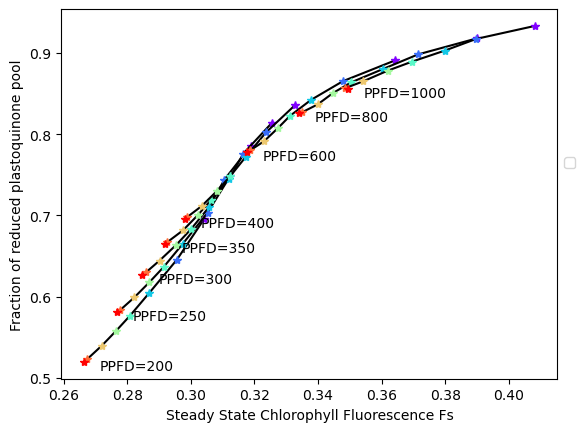

In [38]:
PQ_pool_list = []
PQ_pool_dict ={}
#actiniclight_list = np.linspace(100,1000,20)
#kb6f_multiplier = np.linspace(0.05,1,20)
actiniclight_list =[200,250,300,350,400,600,800,1000]
kb6f_multiplier = [0.1,0.125,0.15,0.175,0.2,0.25,0.5,1]
s1= Simulator(m)
s1.initialise(y0)
s1.update_parameter("kcyc", 0.0)
s1.clear_results()
ss_dict ={}
ss_list=[]
i_dict={}
i_list=[]
g_dict={}
g_list=[]
for h in tqdm(actiniclight_list):
    PQ_pool_list = []
    ss_list=[]
    i_list=[]
    g_list=[]
    for j in kb6f_multiplier:
        s1= Simulator(m)
        s1.initialise(y0)
        s1.update_parameter("kcyc", 0.0)
        s1.clear_results()
        s1.update_parameter("kCytb6f", 1*j)
        pam_analysis(s1,t_relax=120,t_pulse=0.8,pfd_dark=50, pfd_illumination=h,
                     pfd_pulse=5000,adaption=50,time_adaption=10000)
        fluxes = s1.get_fluxes_df()
        concentrations = s1.get_full_results_df()
        ss,i,g = get_Fs(s1,10610.0, 10720.0)
        ss_list.append(ss)
        i_list.append(g.index[i])
        g_list.append(g)
        PQ_pool_list.append(s1.get_full_results_df()["PQ_redoxstate"][g.index[i]])
    key = "kb6f: "+ str(h)
    ss_dict[key]=ss_list
    g_dict[key]=g_list
    i_dict[key]=i_list
    PQ_pool_dict[key]=PQ_pool_list
    
    plt.plot(ss_list,PQ_pool_list, color="black")
    if h == 1:
        plt.text(ss_list[-1]+0.005 ,PQ_pool_list[-1]-0.02, "PPFD="+str(h))

    elif h == 0.5:
        plt.text(ss_list[-1]+0.005 ,PQ_pool_list[-1]-0.005, "PPFD="+str(h))        
    else:
        plt.text(ss_list[-1]+0.005 ,PQ_pool_list[-1]-0.01, "PPFD="+str(h))
    for p in range(len(ss_list)):
        if h == 0.1:
            plt.plot(ss_list[p], PQ_pool_list[p], color=color[p], label="ppfd: "+str(actiniclight_list[p])+" "+r'$\mu$'+"mol $m^{-2}$"+"$s^{-1}$", marker = "*")
        else:
            plt.plot(ss_list[p], PQ_pool_list[p], color=color[p], marker = "*")

plt.xlabel("Steady State Chlorophyll Fluorescence Fs")
plt.ylabel("Fraction of reduced plastoquinone pool")
plt.legend(loc="lower left", bbox_to_anchor=(1, 0.55))
plt.show()


In [14]:
color = cm.rainbow(np.linspace(0, 1, 8))

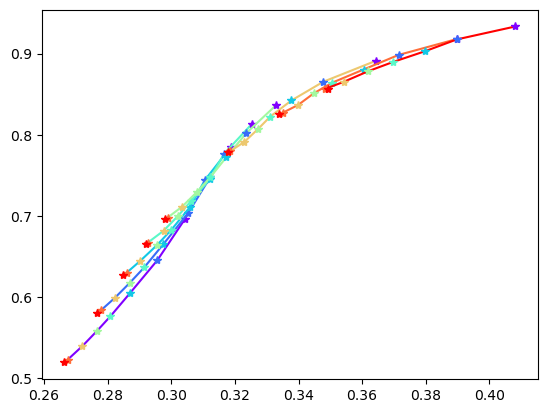

In [32]:
for i in range(len(ss_dict.values())):
    plt.plot(list(ss_dict.values())[i],list(PQ_pool_dict.values())[i], color = color[i], label = list(ss_dict.keys())[i])
    for p in range(len(ss_list)):
            plt.plot(list(ss_dict.values())[i][p] ,list(PQ_pool_dict.values())[i][p], color=color[p], label="ppfd: "+str(actiniclight_list[p])+" "+r'$\mu$'+"mol $m^{-2}$"+"$s^{-1}$", marker = "*")
            #plt.plot(list(ss_dict.values())[i][p] ,list(PQ_pool_dict.values())[i][p], color=color[p], marker = "*")
            #plt.text(list(ss_dict.values())[i][p] ,list(PQ_pool_dict.values())[i][p], "kb6f="+str(1*kb6f_multiplier[i]))
#plt.legend()

In [ ]:
plt.plot(ss_list,list(PQ_pool_dict.values()), color="black")
    if h == 1:
        plt.text(ss_list[-1]+0.005 ,list(PQ_pool_dict.values())[-1]-0.02, "kCytb6f="+str(2.5*h))

    elif h == 0.5:
        plt.text(ss_list[-1]+0.005 ,list(PQ_pool_dict.values())[-1]-0.005, "kCytb6f="+str(2.5*h))        
    else:
        plt.text(ss_list[-1]+0.005 ,list(PQ_pool_dict.values())[-1]-0.01, "kCytb6f="+str(2.5*h))
    for p in range(len(ss_list)):
        if h == 0.1:
            plt.plot(ss_list[p], list(PQ_pool_dict.values())[p], color=color[p], label="ppfd: "+str(actiniclight_list[p])+" "+r'$\mu$'+"mol $m^{-2}$"+"$s^{-1}$", marker = "*")
        else:
            plt.plot(ss_list[p], list(PQ_pool_dict.values())[p], color=color[p], marker = "*")

plt.xlabel("Steady State Chlorophyll Fluorescence Fs")
plt.ylabel("Fraction of reduced plastoquinone pool")
plt.legend(loc="lower left", bbox_to_anchor=(1, 0.55))
plt.show()

In [30]:
"""why is reduced pq pool so high even in high light?!?!?
maybe cyclic electtron flow beacuse of stress and as its the limitng factor
cant convert fast enough? else it should get lower?"""

'why is reduced pq pool so high even in high light?!?!?\nmaybe cyclic electtron flow beacuse of stress and as its the limitng factor\ncant convert fast enough? else it should get lower?'

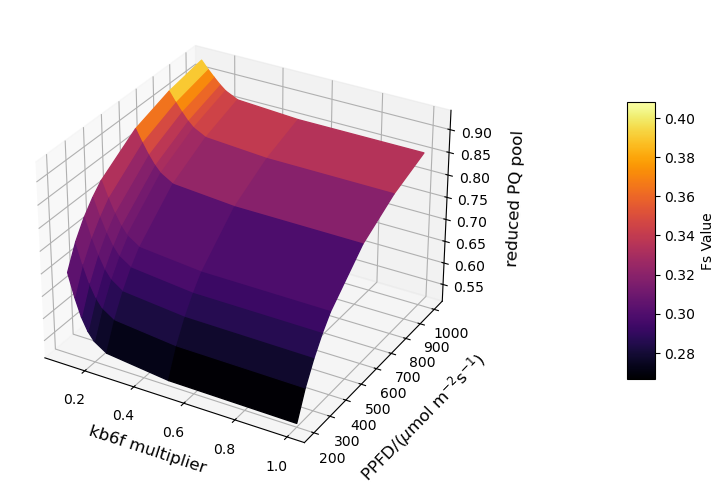

In [39]:
fig, ax1 = plt.subplots(1,1, figsize=(20, 6), subplot_kw={"projection": "3d"})
colorbar=plt.cm.ScalarMappable(cmap='inferno')
fcolors = colorbar.to_rgba(np.array(list(ss_dict.values())).reshape(8,8))
ax = ax1

surf = ax.plot_surface(
    *np.meshgrid(kb6f_multiplier,actiniclight_list),
    np.array(list(PQ_pool_dict.values())).reshape(8,8),
    facecolors=fcolors,
    cmap='inferno'
)
ax.set_xlabel("kb6f multiplier", labelpad=5, size=12)
ax.set_ylabel("PPFD/($\mu$mol m$^{-2}$s$^{-1}$)", labelpad=10, size=12)
ax.set_zlabel("reduced PQ pool", labelpad=10, size=12)
fig.colorbar(colorbar, shrink=0.6, aspect=10, ax=ax, pad=0.1, label="Fs Value")


In [ ]:
 c = s.get_full_results_df()
    g = (s.get_full_results_df()["Fluo"][start:end])/max(c["Fluo"])
    for i in range(20,len(g)):
        if i == (len(g)-4):
            ss = g.iloc[-4]
            print("finished with Fs:", ss, "at i:",i)
            break
        ssc=g.iloc[i]
        control = g.iloc[i+1]
        control2 = g.iloc[i+2]
        control3 = g.iloc[i+3]
        control4= g.iloc[i+4]
        if control < ((0.0000000001*ssc)+ssc and control > (ssc-(0.0000000001*ssc))) and control2 < (((0.000000001*ssc)+ssc) and control2 > (ssc-(0.0000000001*ssc))) and control3 < ((0.0000000001*ssc)+ssc and control3 > (ssc-(0.0000000001*ssc))) and control4 < ((0.0000000001*ssc)+ssc and control4 > (ssc-(0.0000000001*ssc))):
            ss = ssc
            print("finished with Fs:", ss, "at i:",i)
            break
    return ss, i, g

In [39]:
def get_Fs(s:Simulator) -> Tuple[int, int, np.array]:
    c = s.get_full_results_df()
    g = (s.get_full_results_df()["Fluo"][65420:65523]/max(s.get_full_results_df()["Fluo"]))
    for i in range(20,len(g)):
        if i == (len(g)-4):
            ss = g.iloc[-4]
            print("finished with Fs:", ss, "at i:",i)
            break
        ssc=g.iloc[i]
        control = g.iloc[i+1]
        control2 = g.iloc[i+2]
        control3 = g.iloc[i+3]
        control4= g.iloc[i+4]
        if control < ((0.0000000001*ssc)+ssc and control > (ssc-(0.0000000001*ssc))) and control2 < (((0.000000001*ssc)+ssc) and control2 > (ssc-(0.0000000001*ssc))) and control3 < ((0.0000000001*ssc)+ssc and control3 > (ssc-(0.0000000001*ssc))) and control4 < ((0.0000000001*ssc)+ssc and control4 > (ssc-(0.0000000001*ssc))):
            ss = ssc
            print("finished1")
            break
    print(ss)
    print(i)
    return ss, i, g

def constant_light_cond2(s: Simulator, days: float, measuring_day: int, 
                        time_relax: float, time_pulse: float,
                        pfd_dark:float, pfd_light:float, pfd_pulse: float,):
    pfds = [120,240,120,50]
    t = [5400, 46800+5400, 46800+5400*2, 46800+28800+5400*2]
    measuring_pfds = list([pfd_dark,pfd_pulse] * 2
        + [pfd_light,pfd_pulse] * 10
        + [pfd_dark,pfd_pulse] * 8)
    measuring_time = list(it.accumulate(it.chain.from_iterable((time_relax, time_pulse) for i  in range(32))))
    for f in range(len(measuring_time)):
        measuring_time[f]= measuring_time[f] + (7200+46800+5400*2) + (86400*measuring_day)
    special_t =[5400, 46800+5400, 46800+5400*2, 7200+46800+5400*2, 86400]
    special_pfds =[120,240,120,50,50]
    for d_time in range(0,(days+1)):
        update_t = [i + (86400*(d_time)) for i in t]
        if d_time != measuring_day:
            for time, pfd in zip(update_t, pfds):
                    #print(time,pfd)
                    s.update_parameter("pfd", pfd)
                    s.simulate(time)
        else:
            update_special_t = [i+(86400*d_time) for i in special_t]
            for time, pfd in zip(update_special_t, special_pfds):
                #print(time, pfd)
                s.update_parameter("pfd", pfd)
                s.simulate(time)
                if time == (7200+46800+5400*2) + (86400*d_time):
                    for time, pfd in zip(measuring_time, measuring_pfds):
                        #print(time,pfd)
                        s.update_parameter("pfd", pfd)
                        s.simulate(time)

  0%|          | 0/8 [00:00<?, ?it/s]

finished with Fs: 0.3043583333741398 at i: 49
0.3043583333741398
49
finished with Fs: 0.31046085630103076 at i: 47
0.31046085630103076
47
finished with Fs: 0.31693456397033565 at i: 46
0.31693456397033565
46
finished with Fs: 0.3264344562040632 at i: 32
0.3264344562040632
32
finished with Fs: 0.3333342757775123 at i: 35
0.3333342757775123
35
finished with Fs: 0.36402979770402516 at i: 30
0.36402979770402516
30
finished with Fs: 0.3899839471181053 at i: 30
0.3899839471181053
30
finished with Fs: 0.4102617114600395 at i: 25
0.4102617114600395
25
finished with Fs: 0.29548448742710753 at i: 66
0.29548448742710753
66
finished with Fs: 0.30415782412829356 at i: 56
0.30415782412829356
56
finished with Fs: 0.3113055109142027 at i: 40
0.3113055109142027
40
finished with Fs: 0.31765312932564455 at i: 41
0.31765312932564455
41
finished with Fs: 0.3220835559073664 at i: 46
0.3220835559073664
46
finished with Fs: 0.3479696137237549 at i: 39
0.3479696137237549
39
finished with Fs: 0.3722459118571854

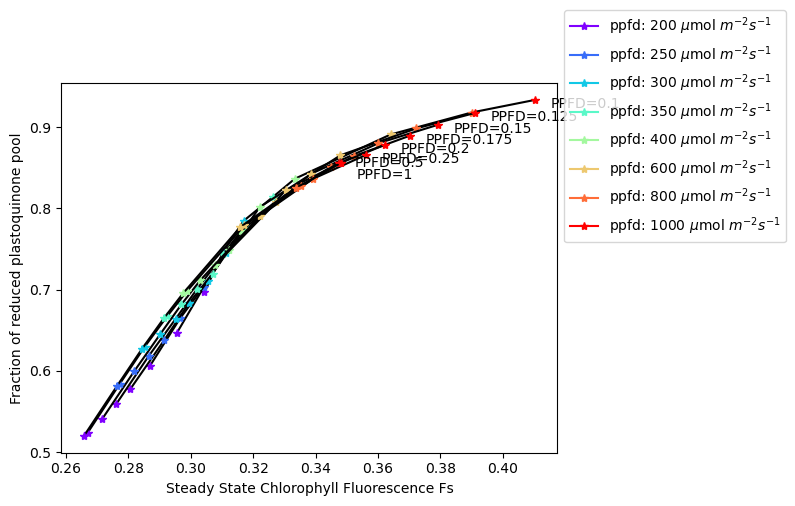

In [40]:
PQ_pool_list = []
PQ_pool_dict ={}
#actiniclight_list = np.linspace(100,1000,20)
#kb6f_multiplier = np.linspace(0.05,1,20)
actiniclight_list =[200,250,300,350,400,600,800,1000]
kb6f_multiplier = [0.1,0.125,0.15,0.175,0.2,0.25,0.5,1]
s1= Simulator(m)
s1.initialise(y0)
s1.update_parameter("kcyc", 0.0)
s1.clear_results()
ss_dict ={}
ss_list=[]
i_dict={}
i_list=[]
g_dict={}
g_list=[]
for h in tqdm(kb6f_multiplier):
    PQ_pool_list = []
    ss_list=[]
    i_list=[]
    g_list=[]
    for j in actiniclight_list:
        s1= Simulator(m)
        s1.initialise(y0)
        s1.update_parameter("kcyc", 0.0)
        s1.clear_results()
        s1.update_parameter("kCytb6f", 1*h)
        constant_light_cond2(s1, days = 0, measuring_day=0,  
                         time_relax=120, time_pulse= 0.8,
                         pfd_dark=50, pfd_light=j, pfd_pulse=4100)        
        fluxes = s1.get_fluxes_df()
        concentrations = s1.get_full_results_df()
        ss,i,g = get_Fs(s1)
        ss_list.append(ss)
        i_list.append(g.index[i])
        g_list.append(g)
        PQ_pool_list.append(s1.get_full_results_df()["PQ_redoxstate"][g.index[i]])
    key = "kb6f: "+ str(h)
    ss_dict[key]=ss_list
    g_dict[key]=g_list
    i_dict[key]=i_list
    PQ_pool_dict[key]=PQ_pool_list
    
    plt.plot(ss_list,PQ_pool_list, color="black")
    if h == 1:
        plt.text(ss_list[-1]+0.005 ,PQ_pool_list[-1]-0.02, "PPFD="+str(h))

    elif h == 0.5:
        plt.text(ss_list[-1]+0.005 ,PQ_pool_list[-1]-0.005, "PPFD="+str(h))        
    else:
        plt.text(ss_list[-1]+0.005 ,PQ_pool_list[-1]-0.01, "PPFD="+str(h))
    for p in range(len(ss_list)):
        if h == 0.1:
            plt.plot(ss_list[p], PQ_pool_list[p], color=color[p], label="ppfd: "+str(actiniclight_list[p])+" "+r'$\mu$'+"mol $m^{-2}$"+"$s^{-1}$", marker = "*")
        else:
            plt.plot(ss_list[p], PQ_pool_list[p], color=color[p], marker = "*")

plt.xlabel("Steady State Chlorophyll Fluorescence Fs")
plt.ylabel("Fraction of reduced plastoquinone pool")
plt.legend(loc="lower left", bbox_to_anchor=(1, 0.55))
plt.show()

(64050.0, 66160.0)

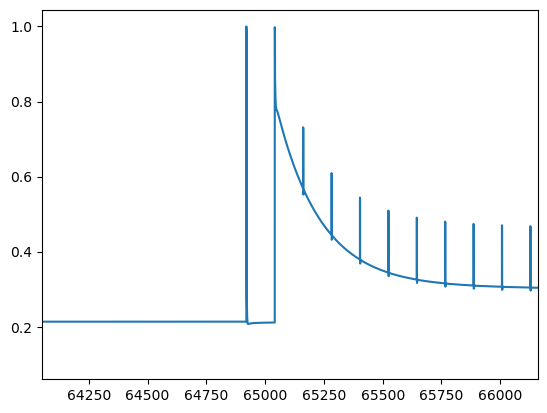

In [57]:
plt.plot(s1.get_full_results_df()["Fluo"]/max(s1.get_full_results_df()["Fluo"]))
plt.xlim(64050,66160)

In [12]:
color = cm.rainbow(np.linspace(0, 1, 8))

In [38]:

s1= Simulator(get_model())
s1.initialise(y0)
s1.clear_results()
constant_light_cond2(s1, days = 0, measuring_day=0,  
                         time_relax=120, time_pulse= 0.8,
                         pfd_dark=50, pfd_light=500, pfd_pulse=4100)

In [9]:
PQ_pool_list = []
PQ_pool_dict ={}

kb6f_multiplier = [0.001,0.01,0.1,0.25,0.5,1,2]
s1= Simulator(get_model())
s1.initialise(y0)
s1.update_parameter("kcyc", 0.0)
s1.clear_results()
ss_list=[]
i_list=[]
g_list=[]

for h in kb6f_multiplier:
    PQ_pool_list = []
    s1= Simulator(get_model())
    s1.initialise(y0)
    s1.update_parameter("kcyc", 0.0)
    s1.update_parameter("kCytb6f", 2.5*h)
    s1.clear_results()
    constant_light_cond2(s1, days = 0, measuring_day=0,  
                         time_relax=120, time_pulse= 0.8,
                         pfd_dark=50, pfd_light=500, pfd_pulse=4100)
    ss,i,g = get_Fs(s1)
    ss_list.append(ss)
    i_list.append(g.index[i])
    g_list.append(g)
    PQ_pool_list.append(s1.get_full_results_df()["PQ_redoxstate"][g.index[i]])
    key = "pfd: "+ str(j)
    PQ_pool_dict[key]=PQ_pool_list

TypeError: 'NoneType' object is not subscriptable

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

for j in range(0,8):
    ax.plot((Fluo[j]/0.7255982138019874), color=color[j], label="normalised fluorescence at " +str(actiniclight_list [j])+" umol")
    ax.plot(i_list[j], ss_list[j], color="black", label="Fs at ("+str(round(ss_list[j],4))+"|"+str(round(i_list[j],4))+")", marker = "*")
ax.axvspan(0, 2 * 120, color=(0, 0, 0, 1 / 4))
ax.axvspan(12 * 120, 21 * 120, color=(0, 0, 0, 1 / 4))
ax.set(
    xlim=(64900,67500),
    xlabel="Time/(s)",
    ylabel="Fluorescence (normalised)",
)

ax.legend(loc="lower right")
plt.title("Fs values for different actinic light intensities",)
plt.show()

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(ss_list,list(PQ_pool_dict.values()), color="black")
for i in range(len(ss_list)):
    ax.plot(ss_list[i], list(PQ_pool_dict.values())[i], color=color[i], label="pfd: "+str(actiniclight_list[i]), marker = "*")
ax.set(
    xlabel="steady state Fluorescence Fs",
    ylabel="fraction of reduced PQ pool",
)
ax.legend(loc="upper right")
plt.title("reduced PQ pool depending on Fs value")
plt.show()

In [78]:
def get_Fs_2(s:Simulator) -> Tuple[int, int, np.array]:
    c = s.get_full_results_df()
    g = (s.get_full_results_df()["Fluo"][1088.03:1207.23])/max(c["Fluo"])
    for i in range(20,len(g.iloc[20:])):
        ssc=g.iloc[i]
        if i >= (len(g.iloc[20:])-4):
            ss = ssc
            ssi = i
            print("finished")
            break
        control = g.iloc[i+1]
        control2 = g.iloc[i+2]
        control3 = g.iloc[i+3]
        control4= g.iloc[i+4]
        if control < ((0.0000000001*ssc)+ssc and control > (ssc-(0.0000000001*ssc))) and control2 < (((0.000000001*ssc)+ssc) and control2 > (ssc-(0.0000000001*ssc))) and control3 < ((0.0000000001*ssc)+ssc and control3 > (ssc-(0.0000000001*ssc))) and control4 < ((0.0000000001*ssc)+ssc and control4 > (ssc-(0.0000000001*ssc))):
            ss = ssc
            ssi = i
            print("finished1")
            break
    print(ss)
    print(i)
    return ss, i, g

  0%|          | 0/7 [00:00<?, ?it/s]

simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished1
0.3095282350297797
20


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished1
0.31372264979891523
20


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished1
0.3184971474578492
20


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished1
0.32405350486029316
20


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished1
0.3302042476034702
20


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished1
0.3540293296062453
135


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished1
0.37616937473966544
145


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished1
0.3932905271596771
101


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished1
0.3062616500177165
20


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished1
0.31096488393759814
20


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished1
0.31455135585470007
20


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished1
0.318473920098374
20


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished1
0.3226800474476407
20


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished1
0.3406810908292162
120


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished1
0.3602341783317517
133


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished1
0.37692831095720214
152


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished1
0.2994977141384688
20


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished1
0.3086748992545288
20


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished1
0.3130984546873828
20


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished1
0.3164486634082386
20


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished1
0.31973894728998636
20


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished1
0.3334113655655063
118


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished1
0.3499923363545051
118


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished1
0.36819765470748084
20


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished1
0.29204537864408914
20


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished1
0.3033140436234528
20


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished1
0.3103814389810179
20


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished1
0.3153090630266832
20


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished1
0.3182657490789735
20


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished1
0.3313151357864079
20


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished1
0.3436150613477141
120


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished1
0.3601289209550945
20


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished1
0.28764279071462984
20


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished1
0.29823132134991326
20


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished1
0.3066053816018672
20


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished1
0.31391157145123016
20


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished1
0.31746997572339725
20


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished1
0.32923300559967156
20


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished1
0.34180697568410007
20


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished1
0.35455117194306546
20


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished1
0.2751275973667681
20


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished1
0.28751067810054487
20


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished1
0.2965684964780923
20


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished1
0.3037662766912641
20


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished1
0.3114517796905384
20


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished1
0.3266692809998057
20


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished1
0.3367471907303464
20


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished1
0.3465117451586562
20


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished1
0.24610884135894986
20


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished1
0.2570786288560884
20


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished1
0.26807446927024375
20


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished1
0.2816293309926233
20


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished1
0.2919420896830404
20


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished1
0.31892876857739383
20


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished1
0.3315605035115547
20


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

finished1
0.3403225078836527
20


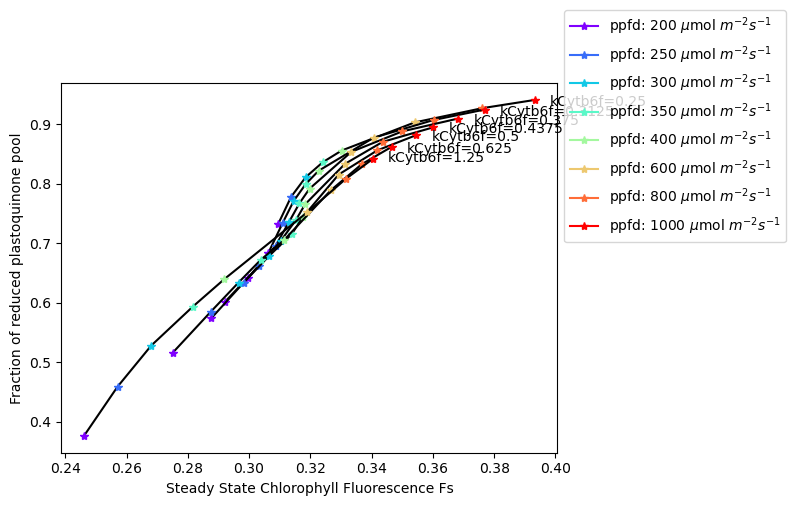

In [82]:
PQ_pool_list = []
PQ_pool_dict ={}
actiniclight_list =[200,250,300,350,400,600,800,1000]
kb6f_multiplier = [0.1,0.125,0.15,0.175,0.2,0.25,0.5]
s1= Simulator(get_model())
s1.initialise(y0)
s1.update_parameter("kcyc", 0.0)
s1.clear_results()
ss_list=[]
i_list=[]
g_list=[]
for h in tqdm(kb6f_multiplier):
    PQ_pool_dict={}
    i_list=[]
    g_list=[]
    ss_list=[]
    for j in actiniclight_list:
        PQ_pool_list = []
        s1= Simulator(get_model())
        s1.initialise(y0)
        s1.update_parameter("kcyc", 0.0)
        s1.update_parameter("kCytb6f", 2.5*h)
        s1.clear_results()
        pam_analysis(s1,t_relax=120,t_pulse=0.8, pfd_dark= 50,
                     pfd_illumination= j,pfd_pulse= 4100)
        ss,i,g = get_Fs_2(s1)
        ss_list.append(ss)
        i_list.append(g.index[i])
        g_list.append(g)
        PQ_pool_list.append(s1.get_full_results_df()["PQ_redoxstate"][g.index[i]])
        key = "pfd: "+ str(j)
        PQ_pool_dict[key]=PQ_pool_list[0]
        
    plt.plot(ss_list,list(PQ_pool_dict.values()), color="black")
    if h == 1:
        plt.text(ss_list[-1]+0.005 ,list(PQ_pool_dict.values())[-1]-0.02, "kCytb6f="+str(2.5*h))

    elif h == 0.5:
        plt.text(ss_list[-1]+0.005 ,list(PQ_pool_dict.values())[-1]-0.005, "kCytb6f="+str(2.5*h))        
    else:
        plt.text(ss_list[-1]+0.005 ,list(PQ_pool_dict.values())[-1]-0.01, "kCytb6f="+str(2.5*h))
    for p in range(len(ss_list)):
        if h == 0.1:
            plt.plot(ss_list[p], list(PQ_pool_dict.values())[p], color=color[p], label="ppfd: "+str(actiniclight_list[p])+" "+r'$\mu$'+"mol $m^{-2}$"+"$s^{-1}$", marker = "*")
        else:
            plt.plot(ss_list[p], list(PQ_pool_dict.values())[p], color=color[p], marker = "*")

plt.xlabel("Steady State Chlorophyll Fluorescence Fs")
plt.ylabel("Fraction of reduced plastoquinone pool")
plt.legend(loc="lower left", bbox_to_anchor=(1, 0.55))
plt.show()

  0%|          | 0/7 [00:00<?, ?it/s]

finished1
0.2926063816399393
20
finished
0.2978547137603809
36
finished
0.3033495184768281
35
finished
0.309360450188925
32
finished
0.31580143844928743
28
finished
0.34219269321052576
25
finished
0.3644903459885352
20
finished
0.3815126778621053
23
finished1
0.2853625495527978
20
finished1
0.2903500695285806
20
finished
0.2946941985317322
36
finished
0.29907894058052176
32
finished
0.3037127630039873
33
finished
0.3241299326200592
27
finished
0.34378273640647505
29
finished
0.3604166030671972
24
finished1
0.28022834778782013
20
finished1
0.2858053159332882
20
finished1
0.29006702548037866
20
finished
0.2938534028937581
37
finished
0.2975877926005701
36
finished
0.31378698604164096
30
finished
0.33064518069709214
29
finished
0.34600196409549366
25
finished1
0.2760336251274903
20
finished1
0.28236631228159087
20
finished1
0.28698378557336585
20
finished1
0.2907589771507362
20
finished
0.29416708646181516
39
finished
0.30779265257227484
31
finished
0.3222503334779032
28
finished
0.336088

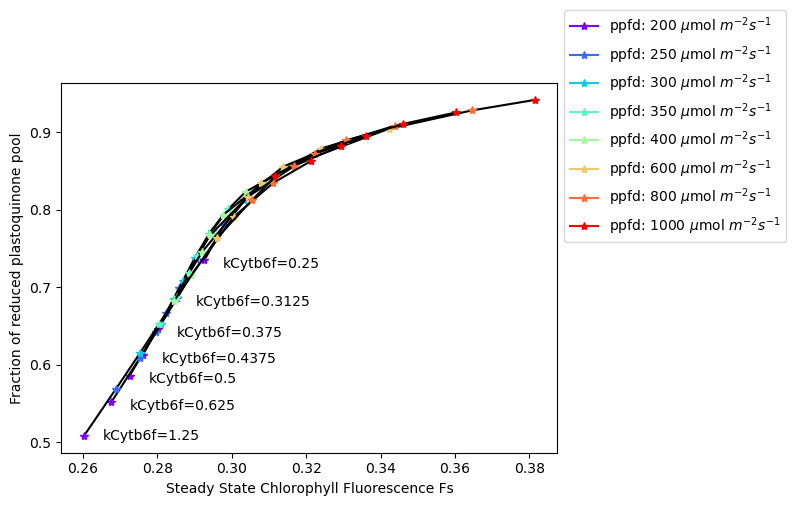

In [18]:
PQ_pool_list = []
PQ_pool_dict ={}
actiniclight_list =[200,250,300,350,400,600,800,1000]
kb6f_multiplier = [0.1,0.125,0.15,0.175,0.2,0.25,0.5]
s1= Simulator(get_model())
s1.initialise(y0)
s1.update_parameter("kcyc", 0.0)
s1.clear_results()
ss_list=[]
i_list=[]
g_list=[]
for h in tqdm(kb6f_multiplier):
    PQ_pool_dict={}
    i_list=[]
    g_list=[]
    ss_list=[]
    for j in actiniclight_list:
        PQ_pool_list = []
        s1= Simulator(get_model())
        s1.initialise(y0)
        s1.update_parameter("kcyc", 0.0)
        s1.update_parameter("kCytb6f", 2.5*h)
        s1.clear_results()
        constant_light_cond2(s1, days = 0, measuring_day=0,  
                         time_relax=120, time_pulse= 0.8,
                         pfd_dark=50, pfd_light=j, pfd_pulse=4100)
        ss,i,g = get_Fs(s1)
        ss_list.append(ss)
        i_list.append(g.index[i])
        g_list.append(g)
        PQ_pool_list.append(s1.get_full_results_df()["PQ_redoxstate"][g.index[i]])
        key = "pfd: "+ str(j)
        PQ_pool_dict[key]=PQ_pool_list[0]
        
    plt.plot(ss_list,list(PQ_pool_dict.values()), color="black")
    if h == 1:
        plt.text(ss_list[0]+0.005 ,list(PQ_pool_dict.values())[0]-0.02, "kCytb6f="+str(2.5*h))

    elif h == 0.5:
        plt.text(ss_list[0]+0.005 ,list(PQ_pool_dict.values())[0]-0.005, "kCytb6f="+str(2.5*h))        
    else:
        plt.text(ss_list[0]+0.005 ,list(PQ_pool_dict.values())[0]-0.01, "kCytb6f="+str(2.5*h))
    for p in range(len(ss_list)):
        if h == 0.1:
            plt.plot(ss_list[p], list(PQ_pool_dict.values())[p], color=color[p], label="ppfd: "+str(actiniclight_list[p])+" "+r'$\mu$'+"mol $m^{-2}$"+"$s^{-1}$", marker = "*")
        else:
            plt.plot(ss_list[p], list(PQ_pool_dict.values())[p], color=color[p], marker = "*")

plt.xlabel("Steady State Chlorophyll Fluorescence Fs")
plt.ylabel("Fraction of reduced plastoquinone pool")
plt.legend(loc="lower left", bbox_to_anchor=(1, 0.55))
plt.show()

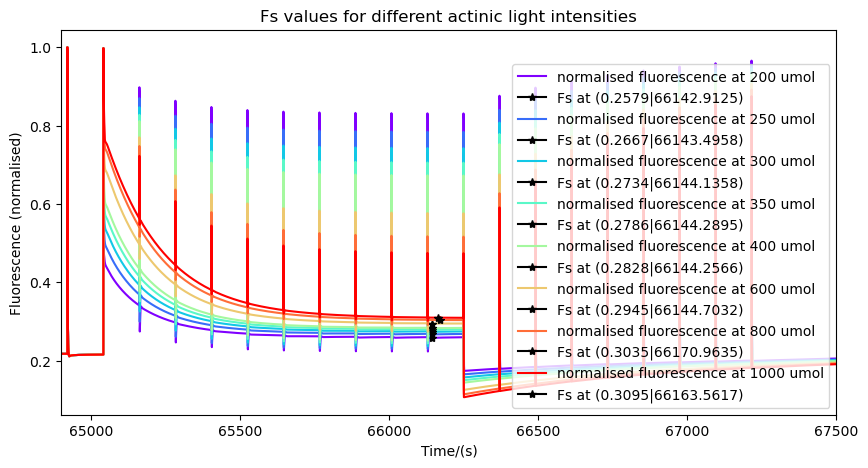

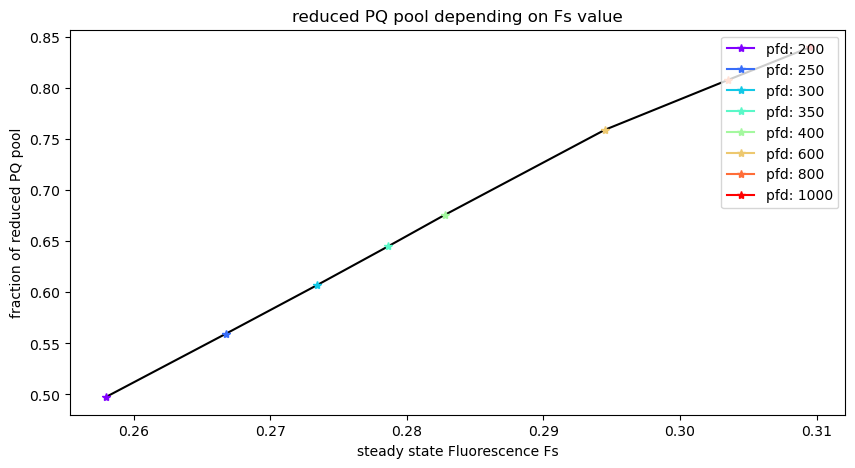

In [185]:
fig, ax = plt.subplots(figsize=(10, 5))

for j in range(0,8):
    ax.plot((Fluo[j]/0.7255982138019874), color=color[j], label="normalised fluorescence at " +str(actiniclight_list [j])+" umol")
    ax.plot(i_list[j], ss_list[j], color="black", label="Fs at ("+str(round(ss_list[j],4))+"|"+str(round(i_list[j],4))+")", marker = "*")
ax.axvspan(0, 2 * 120, color=(0, 0, 0, 1 / 4))
ax.axvspan(12 * 120, 21 * 120, color=(0, 0, 0, 1 / 4))
ax.set(
    xlim=(64900,67500),
    xlabel="Time/(s)",
    ylabel="Fluorescence (normalised)",
)

ax.legend(loc="lower right")
plt.title("Fs values for different actinic light intensities",)
plt.show()

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(ss_list,list(PQ_pool_dict.values()), color="black")
for i in range(len(ss_list)):
    ax.plot(ss_list[i], list(PQ_pool_dict.values())[i], color=color[i], label="pfd: "+str(actiniclight_list[i]), marker = "*")
ax.set(
    xlabel="steady state Fluorescence Fs",
    ylabel="fraction of reduced PQ pool",
)
ax.legend(loc="upper right")
plt.title("reduced PQ pool depending on Fs value")
plt.show()


  0%|          | 0/7 [00:00<?, ?it/s]

finished
0.2743351416481661
358
finished
0.2788737052814547
376
finished
0.2837557754666834
368
finished
0.28919837730766557
367
finished
0.2950702847970869
365
finished
0.31942745532969613
354
finished
0.34011566638417884
368
finished
0.3559801875437286
346


NameError: name 'color' is not defined

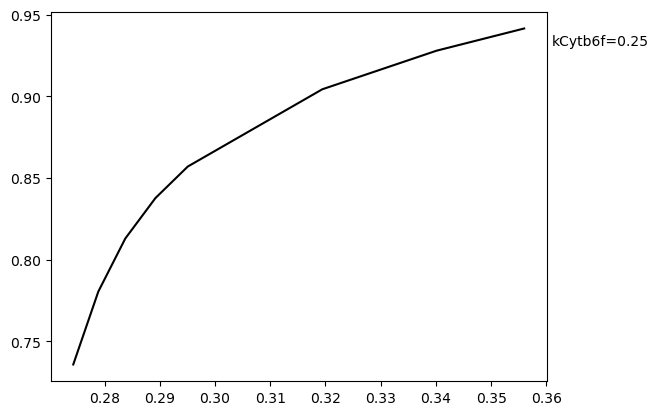

In [8]:
PQ_pool_list = []
PQ_pool_dict ={}
actiniclight_list =[200,250,300,350,400,600,800,1000]
kb6f_multiplier = [0.1,0.125, 0.15,0.175,0.2,0.25,0.5]
s1= Simulator(get_model())
s1.initialise(y0)
s1.update_parameter("kcyc", 0.0)
s1.clear_results()
ss_list=[]
i_list=[]
g_list=[]
for h in tqdm(kb6f_multiplier):
    PQ_pool_dict={}
    i_list=[]
    g_list=[]
    ss_list=[]
    for j in actiniclight_list:
        PQ_pool_list = []
        s1= Simulator(get_model())
        s1.initialise(y0)
        s1.update_parameter("kcyc", 0.0)
        s1.update_parameter("kCytb6f", 2.5*h)
        s1.clear_results()
        constant_light_cond2(s1, days = 0, measuring_day=0,  
                         time_relax=120, time_pulse= 0.8,
                         pfd_dark=50, pfd_light=j, pfd_pulse=4100)
        ss,i,g = get_Fs(s1)
        ss_list.append(ss)
        i_list.append(g.index[i])
        g_list.append(g)
        PQ_pool_list.append(s1.get_full_results_df()["PQ_redoxstate"][g.index[i]])
        key = "pfd: "+ str(j)
        PQ_pool_dict[key]=PQ_pool_list[0]
        
    plt.plot(ss_list,list(PQ_pool_dict.values()), color="black")
    if h == 1:
        plt.text(ss_list[-1]+0.005 ,list(PQ_pool_dict.values())[-1]-0.02, "kCytb6f="+str(2.5*h))

    elif h == 0.5:
        plt.text(ss_list[-1]+0.005 ,list(PQ_pool_dict.values())[-1]-0.005, "kCytb6f="+str(2.5*h))        
    else:
        plt.text(ss_list[-1]+0.005 ,list(PQ_pool_dict.values())[-1]-0.01, "kCytb6f="+str(2.5*h))
    for p in range(len(ss_list)):
        if h == 0.1:
            plt.plot(ss_list[p], list(PQ_pool_dict.values())[p], color=color[p], label="ppfd: "+str(actiniclight_list[p])+" "+r'$\mu$'+"mol $m^{-2}$"+"$s^{-1}$", marker = "*")
        else:
            plt.plot(ss_list[p], list(PQ_pool_dict.values())[p], color=color[p], marker = "*")

plt.xlabel("Steady State Chlorophyll Fluorescence Fs")
plt.ylabel("Fraction of reduced plastoquinone pool")
plt.legend(loc="lower left", bbox_to_anchor=(1, 0.55))
plt.show()

In [19]:
def get_Fs(s:Simulator) -> Tuple[int, int, np.array]:
    c = s.get_full_results_df()
    g = (s.get_full_results_df()["Fluo"][65161.6:66249.6]/0.7255982138019874)
    for i in range(20,len(g.iloc[20:])):
        if i >= (len(g.iloc[20:])-4):
            ss = ssc
            ssi = i
            print("finished")
            break
        ssc=g.iloc[i]
        control = g.iloc[i+1]
        control2 = g.iloc[i+2]
        control3 = g.iloc[i+3]
        control4= g.iloc[i+4]
        if control < ((0.0000000001*ssc)+ssc and control > (ssc-(0.0000000001*ssc))) and control2 < (((0.000000001*ssc)+ssc) and control2 > (ssc-(0.0000000001*ssc))) and control3 < ((0.0000000001*ssc)+ssc and control3 > (ssc-(0.0000000001*ssc))) and control4 < ((0.0000000001*ssc)+ssc and control4 > (ssc-(0.0000000001*ssc))):
            ss = ssc
            ssi = i
            print("finished1")
            break
    print(ss)
    print(i)
    return ss, i, g

def constant_light_cond2(s: Simulator, days: float, measuring_day: int, 
                        time_relax: float, time_pulse: float,
                        pfd_dark:float, pfd_light:float, pfd_pulse: float,):
    pfds = [120,240,120,50]
    t = [5400, 46800+5400, 46800+5400*2, 46800+28800+5400*2]
    measuring_pfds = list([pfd_dark,pfd_dark] * 2
        + [pfd_light,pfd_light] * 10
        + [pfd_dark,pfd_dark] * 8)
    measuring_time = list(it.accumulate(it.chain.from_iterable((time_relax, time_pulse) for i  in range(32))))
    for f in range(len(measuring_time)):
        measuring_time[f]= measuring_time[f] + (7200+46800+5400*2) + (86400*measuring_day)
    special_t =[5400, 46800+5400, 46800+5400*2, 7200+46800+5400*2, 86400]
    special_pfds =[120,240,120,50,50]
    for d_time in range(0,(days+1)):
        update_t = [i + (86400*(d_time)) for i in t]
        if d_time != measuring_day:
            for time, pfd in zip(update_t, pfds):
                    #print(time,pfd)
                    s.update_parameter("pfd", pfd)
                    s.simulate(time)
        else:
            update_special_t = [i+(86400*d_time) for i in special_t]
            for time, pfd in zip(update_special_t, special_pfds):
                #print(time, pfd)
                s.update_parameter("pfd", pfd)
                s.simulate(time)
                if time == (7200+46800+5400*2) + (86400*d_time):
                    for time, pfd in zip(measuring_time, measuring_pfds):
                        #print(time,pfd)
                        s.update_parameter("pfd", pfd)
                        s.simulate(time)

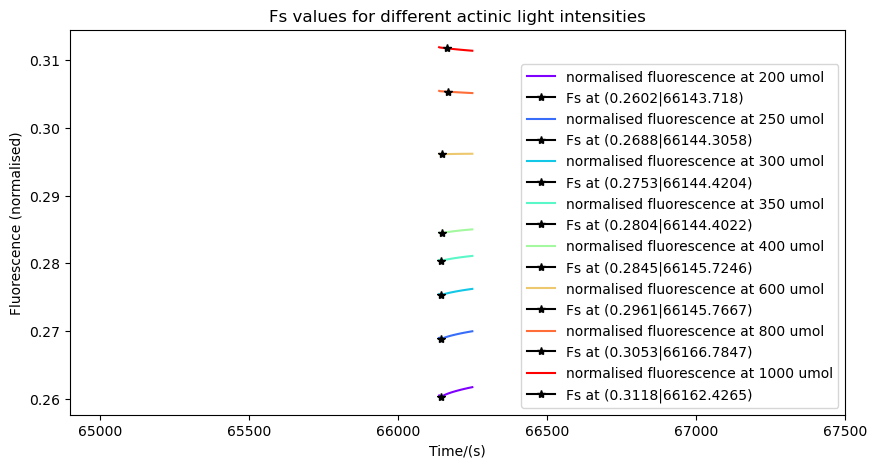

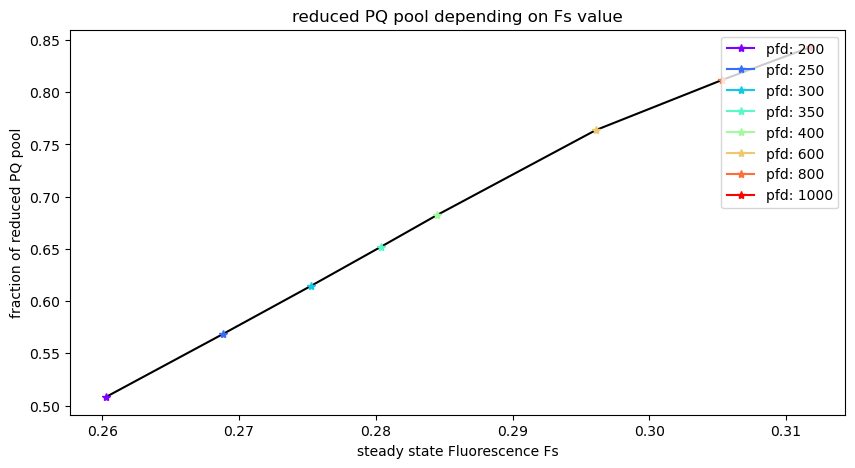

In [20]:
fig, ax = plt.subplots(figsize=(10, 5))

for j in range(0,8):
    ax.plot(g_list[j], color=color[j], label="normalised fluorescence at " +str(actiniclight_list [j])+" umol")
    ax.plot(i_list[j], ss_list[j], color="black", label="Fs at ("+str(round(ss_list[j],4))+"|"+str(round(i_list[j],4))+")", marker = "*")
ax.axvspan(0, 2 * 120, color=(0, 0, 0, 1 / 4))
ax.axvspan(12 * 120, 21 * 120, color=(0, 0, 0, 1 / 4))
ax.set(
    xlim=(64900,67500),
    xlabel="Time/(s)",
    ylabel="Fluorescence (normalised)",
)

ax.legend(loc="lower right")
plt.title("Fs values for different actinic light intensities",)
plt.show()

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(ss_list,list(PQ_pool_dict.values()), color="black")
for i in range(len(ss_list)):
    ax.plot(ss_list[i], list(PQ_pool_dict.values())[i], color=color[i], label="pfd: "+str(actiniclight_list[i]), marker = "*")
ax.set(
    xlabel="steady state Fluorescence Fs",
    ylabel="fraction of reduced PQ pool",
)
ax.legend(loc="upper right")
plt.title("reduced PQ pool depending on Fs value")
plt.show()